In [1]:
import numpy as np
import gc
import lightgbm as lgb
import warnings
import gc
from sklearn.preprocessing import StandardScaler
import matplotlib as  mpl
from matplotlib  import pyplot as plt
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
from datetime import timedelta
from datetime import datetime
warnings.filterwarnings('ignore')

## 0.train_data
针对特定场景数据做相应的处理，不具备通用性  
向下传入up_data(DataFrame)

In [4]:
import pandas as pd
dataset = pd.read_csv('/home/data/NJC/train/dataset.csv', index_col=0)
dbd_faultcode = pd.read_csv('/home/data/NJC/train/dbd_faultcode.csv', encoding='GBK' )
train_data = dataset.merge(dbd_faultcode,how = 'left',on = ["SPN","FMI"])
up_data = train_data
up_data.COLLECTTIME = pd.to_datetime(up_data.COLLECTTIME)
up_data.sort_values(by='COLLECTTIME', inplace=True)
# 删除明显异常的行
drop_rows = [0, 1, 2, 3]
drop_rows.extend([x for x in range(1875076, 1875088)])
up_data.drop(drop_rows, axis=0, inplace=True)
# 默认填充为0
up_data["FLAG"] = 0
# 筛选出故障编码不为空的UNIQUENO(一个UNIQUENO可假设为一台机器)
prob_uniqs = up_data[up_data.CODE.notnull()].UNIQUENO.unique()

In [3]:
# 出现故障的时间段进行标记
'''
minutes = 300
'''
# 设定优先级，对于少数种类的故障，优先标记
code_prev = {
    1206: 0,
    1141: 1,
    1182: 2,
    1168: -1,
    1239: -1,
    1168: -1,
    1211: -1,
    1216: -1,
    1209: -1,
    1145: -1,
    1341: -1,
    1246: -1,
    1215: -1,
    1122: -1
}

delta = timedelta(minutes = 300)
left_delta = delta
right_delta = delta
# 从有故障的设备列表中取出一台设备
for dev_id in prob_uniqs:
    # 取出这台设备的全部数据
    cdf = up_data[up_data.UNIQUENO == dev_id].copy()
    cdf['index'] = cdf.index
    cdf.reset_index(inplace=True)
    # 取出这台设备故障码不为空的数据
    notna_cdf = cdf[cdf.CODE.notna()]
#     print(datetime.now(), dev_id, cdf.shape[0], notna_cdf.shape[0])
    cdf_len = cdf.shape[0]
    # 在这台设备数据中遍历不为空的位置
    for i in notna_cdf.index:
        dt = cdf.at[i, 'COLLECTTIME']
        code = cdf.at[i, 'CODE']
        # 在前后时间间隔内打标签
        for y in range(i, -1, -1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] >= dt - left_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break
        
        for y in range(i + 1, cdf_len, 1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] <= dt + right_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break
print('done')

done
CPU times: user 47.6 s, sys: 900 ms, total: 48.5 s
Wall time: 48.5 s


## 1. 数据筛选，向下传递x_data，util_cols

In [4]:
#columns_filter,util_cols由人工提供
columns_filter = ['CD_VP_UNIQUENO', 'AREA', 'ROAD', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'DIRECTION', 'ALTITUDE', 'ACCSTATE', 'POWERDOWNSTATE', 'LOCATIONSTATE',
       'WORKHOURS', 'ACCRUNTIMES', 'ACCWORKTIMES', 'PRESSURE',
       'WATERTEMPERATURE', 'OILLOCATION', 'OILTEMPERATURE', 'OILPRESSURE',
       'ROUNDSPEED', 'ACCEXCCOUNT', 'GSMSIGNAL', 'WORKDETAILID',
       'VEHICLESTATUS', 'TERMINALSTATUS', 'SATELLITE', 'TERMINALEL_OUTSIDE',
       'TERMINALEL_INSIDE', 'INSIDE_TEMPERATURE', 'INSIDE_HUMIDITY',
       'MILENUMBER', 'OILVALUE1', 'OILVALUE2', 'MIXSTATE', 'QUSHOILTIMES',
       'ENVTEMPERATURE', 'PULSESIGNS', 'ENVHUMIDITY', 'OILPERCENT1',
       'ELCANDVOL', 'WIRELESSTEMP1', 'WIRELESSTEMP2', 'WIRELESSTEMP3',
       'WIRELESSTEMP4', 'SIMNO', 'OPTOILLEVEL', 'ENGINELOADSTATE', 'CMDTYPE',
       'ISANALYSED', 'VERSIONNUM', 'LOCK_INSTRUMENT', 'ALARM_0010',
       'ALARM_0003', 'ALARM_0008', 'ALARM_0005', 'ALARM_0006', 'ALARM_0007',
       'ALARM_0009', 'LOWVOLTAGESTATUS', 'ALARM_0002', 'ALARM_0004',
       'ALARM_0001', 'THROTTLECURRENT', 'CURRENTSPEEDLOADPERCENTAGE',
       'ENGINETORQUEPERCENT', 'ROTATIONALSPEED', 'ENGINERUNTIMES',
       'COOLANTTEMPERATURE', 'ENGINEOILTEMPERATURE', 'INTAKETEMPERATURE',
       'TEMPERATURE', 'LUBRICATINGOILPRESSURE', 'COOLANTLEVEL',
       'INTAKEMANIFOLDTEMPERATURE', 'FUELUSETOTAL', 'OILCONSUMPTIONRATE',
       'CURRENTFAULTCOUNT1', 'CURRENTFAULTCOUNT2', 'CURRENTFAULTCOUNT3',
       'CURRENTFAULTCOUNT4', 'CURRENTFAULTCOUNT5', 'CURRENTFAULTCOUNT6','FLAG','UNIQUENO','COLLECTTIME']
util_cols = ['COLLECTTIME','FLAG','UNIQUENO']

# 筛选出这四类故障的数据
x_train = up_data[up_data.FLAG.isin({0,1206,1141,1182})]
x_data = x_train[columns_filter]
y_train = x_data['FLAG']
y_train.replace(1206,1,inplace=True)
y_train.replace(1141,2,inplace=True)
y_train.replace(1182,3,inplace=True)
x_data['FLAG'] = y_train.values 
x_data.index = pd.to_datetime(x_data['COLLECTTIME'])

## 2. 训练LightGBM 提取重要特征,向下传递x_data，util_cols

In [5]:
def lgb_train(x_train,y_train,x_test = None):
    lgb_train_data = lgb.Dataset(x_train,label=y_train.values.ravel())
    parameters = {
        'num_leaves':100, 
        'max_depth':7,
        'learning_rate':.05,
        'max_bin':200,
        'min_data_in_leaf' : 50,
        'objective':'multiclass',
        'num_class' :4
    }
    num_round=150
    model = lgb.train(parameters,lgb_train_data,num_round)
    y_pred = None
#     y_pred = model.predict(x_test)

    return y_pred,model

lgb_train_x = x_data.drop(columns=util_cols,axis=1)
lgb_train_y = x_data['FALG']
y_pred_lgbm,lgbm = lgb_train(lgb_train_x,lgb_train_y)

In [1]:
#获取的重要特征
booster = lgbm
importance = booster.feature_importance(importance_type='split')
feature_name = booster.feature_name()
feature_dict = {}
for (feature_name,importance) in zip(feature_name,importance):
    feature_dict[feature_name]=importance 
feature_dict = dict(sorted(feature_dict.items(), key=lambda item:item[1],reverse=True)[:20])
feature_list = [key for key in feature_dict.keys()]
x_data = x_data[feature_list+util_cols]

## 3.根据设备的UNIQUENO取数据，做数据处理 
向下传递： 
device_data_all(DataFrame)  
center(array)  
valley_mean(array)

In [890]:
# UNIQUENO需要人工设置，或者遍历xdata['UNIQUENO']
UNIQUENO = 201706130830038670
device_data_all = x_data[x_data.UNIQUENO ==UNIQUENO]

In [917]:
# 定义归一化函数
def standard_scale(x, time):
    x_columns = x.columns
    scaler = StandardScaler()   
    x = scaler.fit_transform(x)
    return pd.DataFrame(x, index = pd.to_datetime(time), columns =x_columns)

# 缺失值处理+全部数据归一化
device_data_all.fillna(0,inplace=True)
device_data_all = standard_scale(device_data_all.drop(columns=util_cols),device_data_all.COLLECTTIME.values)
device_data_all['FLAG'] = util_cols['FLAG']
# 取FLAG=0的数据，即健康数据
device_data = device_data_all[device_data_all.FLAG==0]
device_data.drop(columns=['FLAG'], inplace = True) # 没有util_cols中的列

In [3]:
# Isolation Forest去除异常值
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy import stats

clf = IsolationForest(contamination = 0.025)
clf.fit(device_data)
iso_label = clf.predict(device_data)

# Kmeans 聚类
# 使用筛选后的健康的数据聚类，作为聚类中心,iso_label=1代表"非异常数据"
from sklearn.cluster import KMeans
device_data_health = device_data[iso_label==1]
kmeans  = KMeans(n_clusters=1, random_state=2018).fit(device_data_health.values)
center = kmeans.cluster_centers_

# 计算样本点到聚类中心的距离
dist = np.sqrt(np.sum(np.square(device_data_health.values-center), axis = 1))
device_data_health['dist'] = dist
device_data_health.sort_values(by='dist', inplace=True)

In [929]:
# 核密度的方法寻找聚类边界
import statsmodels.nonparametric.api as smnp
import scipy.signal as signal

def find_peak_valley(x):

    kde = smnp.KDEUnivariate(x)
    kde.fit(kernel = 'gau', bw = 'scott', fft = True, gridsize=100, cut = 3.0, clip=(-np.inf, np.inf))
    x_plot, x_dens = kde.support, kde.density
    x_dens = np.amax(np.c_[np.zeros_like(x_dens), x_dens], axis=1)

    peaks_index, p_heights = signal.find_peaks(x_dens, height=0.01*max(x_dens))
    valleys_index, v_heights = signal.find_peaks(-x_dens)
    return peaks_index, valleys_index, x_plot, x_dens

peaks_index, valleys_index , x_plot, x_dens= find_peak_valley(dist)

# 前三个谷的均值作为聚类边界
valley_mean = np.mean(x_plot[valleys_index[1:2]])

## 4.构建健康基线模型
输出df(Dataframe)

In [933]:
# 计算健康分数，并增加一列'score'
def add_score(valley_mean, device_data, ratio= 0.6):
    score = device_data.dist.values / (valley_mean/0.6)
    device_data_ = device_data
    device_data_['score'] = score
    return device_data_

# 计算每一维特征的偏移程度，并增加相应的 fea+'_bias' 列
def add_bias(center, device_data):
    columns_name = device_data.drop(['dist','score'], axis = 1).columns.values
    df = pd.DataFrame((device_data[columns_name].values - center[0])/center[0],columns=[fea+'_bias' for fea in columns_name],index=device_data.index)
    return pd.concat([device_data, df], axis = 1,copy = False)

# 使用device_data带有所有Flag的
device_data_score = add_score(valley_mean, device_data_all.drop(columns=['FLAG']), ratio= 0.6)
device_data_bias = add_bias(center, device_data_score)

In [934]:
def get_result(device_data_bias):
    score_df = device_data_bias['score'].copy()
    score_df.sort_index(inplace=True)
    date_list = []
    for datetime_stamp in score_df.index:
        date_list.append(''.join([str(datetime_stamp.year),'-',str(datetime_stamp.month),'-',str(datetime_stamp.day)]))
    tmp_list = []
    for date in set(date_list):
        date_score_df = score_df[date]
        filter_score_df = date_score_df[(date_score_df.index>pd.to_datetime(date+' 00:00:00'))&(date_score_df.index<pd.to_datetime(date+' 23:59:59'))]
        tmp_list.append(pd.DataFrame({'date':date,'score':filter_score_df.mean()},index = [0]))

    df = pd.concat(tmp_list,ignore_index=True)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by = 'date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return df
df = get_result(device_data_bias)

## 暂时忽略后面的

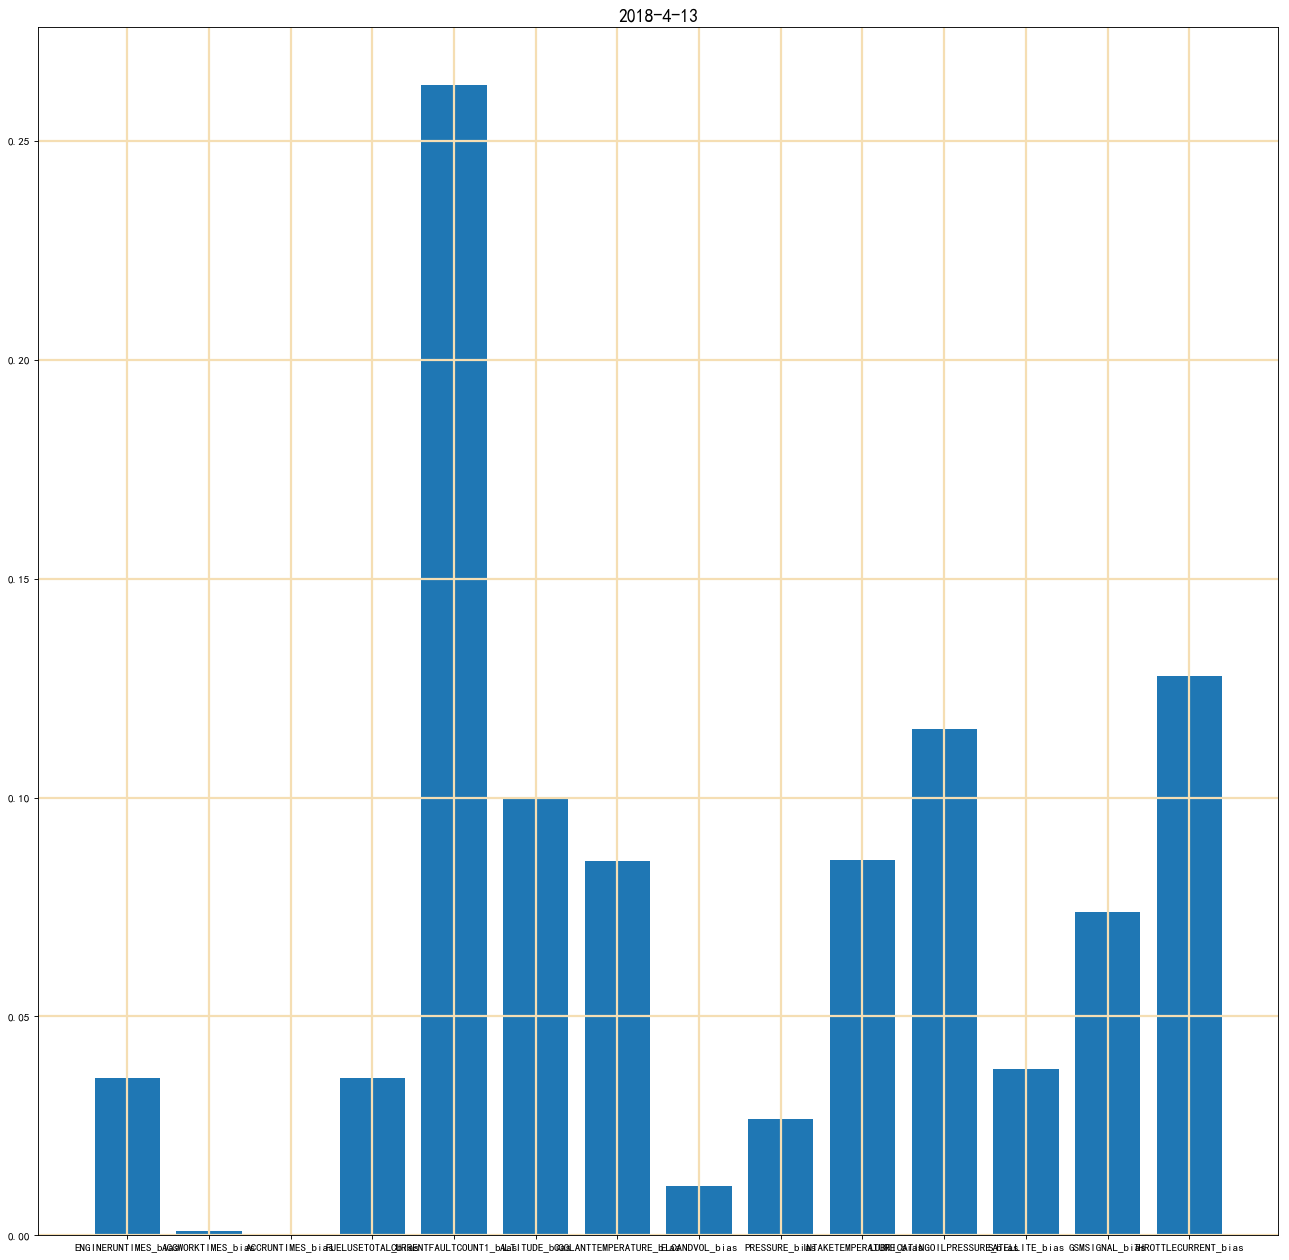

In [936]:
def plot_bar(device_data_bias, date = '2018-4-13'):
    # device_data_bias.index 必须是datetime类型
    df = device_data_bias[(device_data_bias.index>pd.to_datetime(date+' 00:00:00'))&(device_data_bias.index<pd.to_datetime(date+' 23:59:59'))]
    columns_filter = [column for column in df.columns if column.find('bias')!=-1]

    wc_sr = df[columns_filter].abs().mean()

    plt.figure(figsize=(20,20), dpi=80)
    plt.title(date,fontsize = 16)
    plt.grid(True, linestyle = "-", color = "wheat", linewidth = 2.0)
    plt.bar(columns_filter,(wc_sr/wc_sr.sum()).values)
    
    
plot_bar( device_data_bias, '2018-4-13')


## 所有FLAG类型 device_data_all

In [937]:
device_values_all = device_data_all.values
dist_all = np.sqrt(np.sum(np.square(device_values_all-center), axis = 1))
device_data_all['dist'] = dist_all

In [938]:
# device_data_all.drop(columns=['dist','score'], inplace =True)

In [939]:
device_data_score_all = add_score(valley_mean, device_data_all, ratio= 0.6)
device_data_bias_all = add_bias(center, device_data_score_all)
device_data_bias_all.drop(columns=['WORKDETAILID','WORKDETAILID_bias'], inplace= True)

In [940]:
def plot_df_all(df, flag_x, flag_y,UNIQUENO):
    plt.figure(figsize=(16,8), dpi=80)
    plt.grid(True, linestyle = "-", color = "wheat", linewidth = 2.0)
    plt.plot(flag_x, flag_y)
    plt.plot(df['date'],df['score'], color ='sandybrown',linewidth=2.0, linestyle='-',marker = 'o',mec = 'g',mew = 8.0)
    plt.hlines(0.6,xmin=df['date'].min()-timedelta(days=1),xmax = df['date'].max()+timedelta(days=1),colors='darkorange',lw = 4.0)
    plt.hlines(1.0,xmin=df['date'].min()-timedelta(days=1),xmax = df['date'].max()+timedelta(days=1),colors='red',lw = 4.0)
    plt.ylim(0,2)
    plt.xlim(df['date'].min()-timedelta(days=1),df['date'].max()+timedelta(days=1))
    plt.title(str(UNIQUENO)+'工况监控',fontsize = '18')
    plt.xticks(fontsize = '12')
    plt.savefig('./data/%s-all.jpg' %UNIQUENO)
    plt.show()

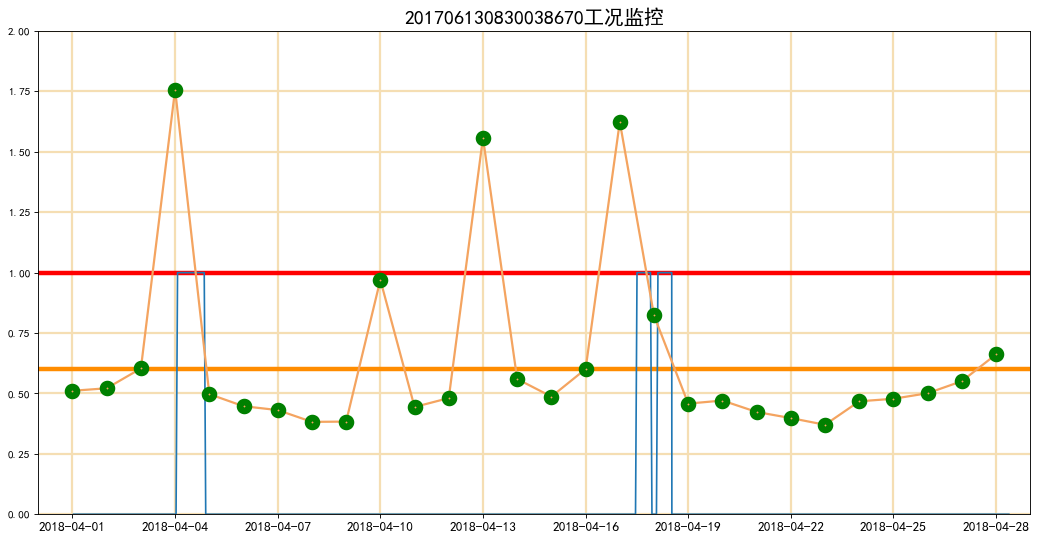

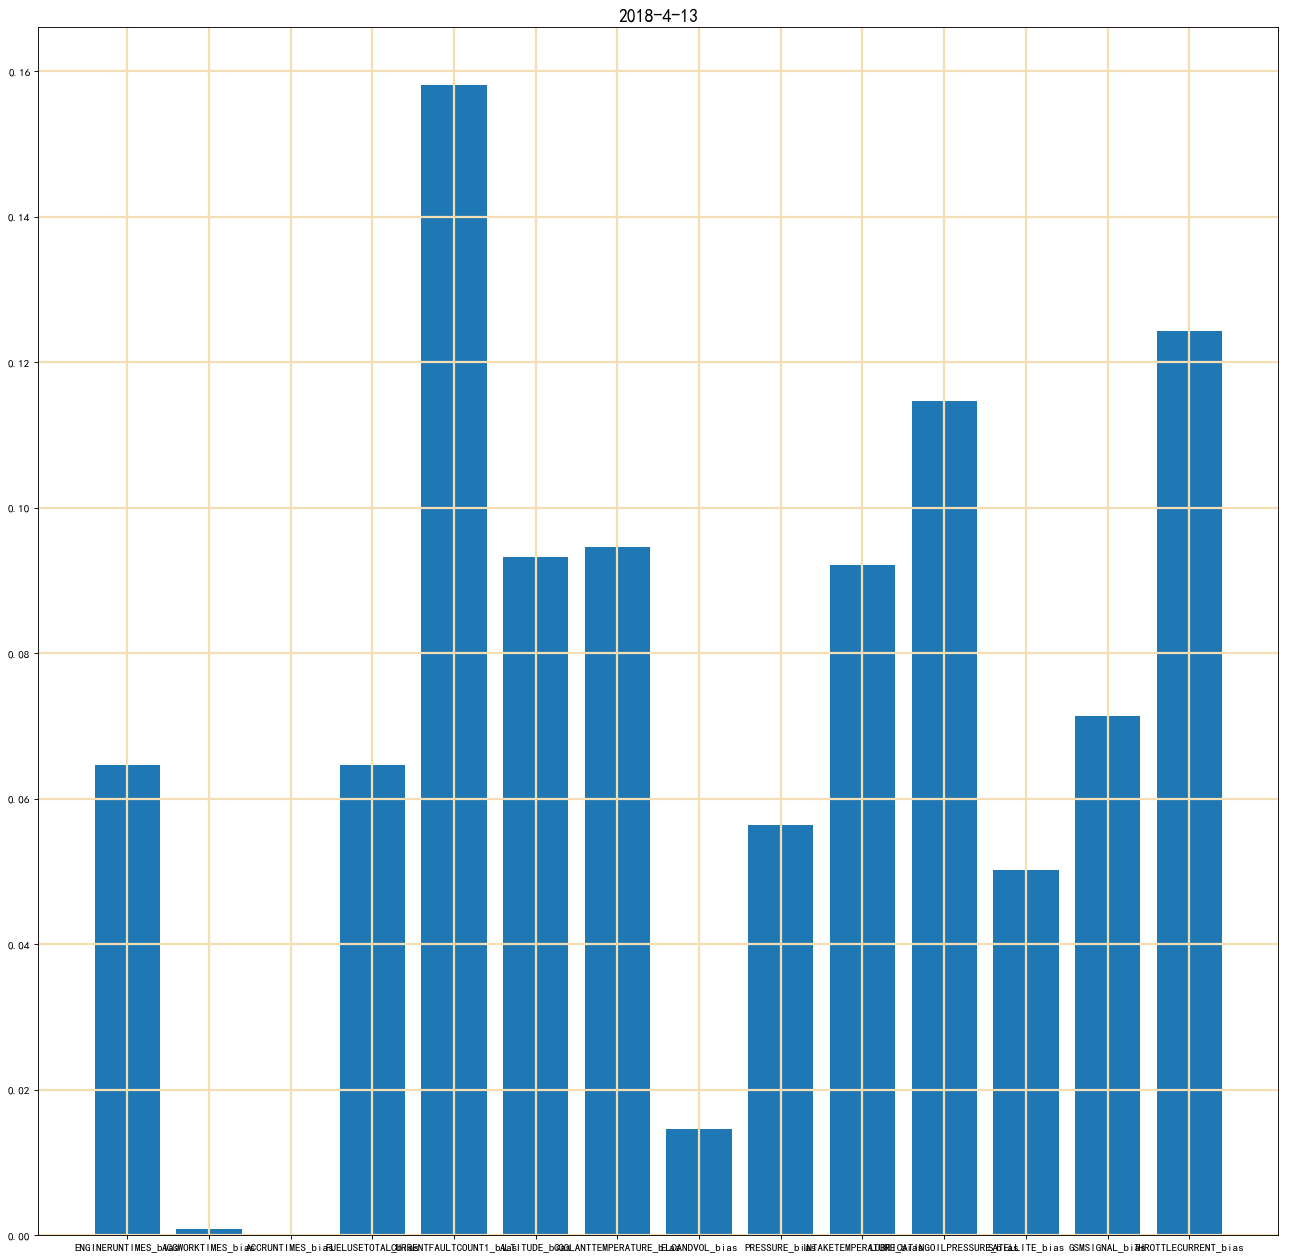

In [941]:
df_all = get_plot_df(device_data_bias_all)
plot_df_all(df_all, device_data_all.index, FLAG_copy,UNIQUENO)
plot_bar( device_data_bias_all, '2018-4-13')

## arima

In [577]:
from scipy import  stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


32.93002391883671 42.25545549006314 35.78090131918211


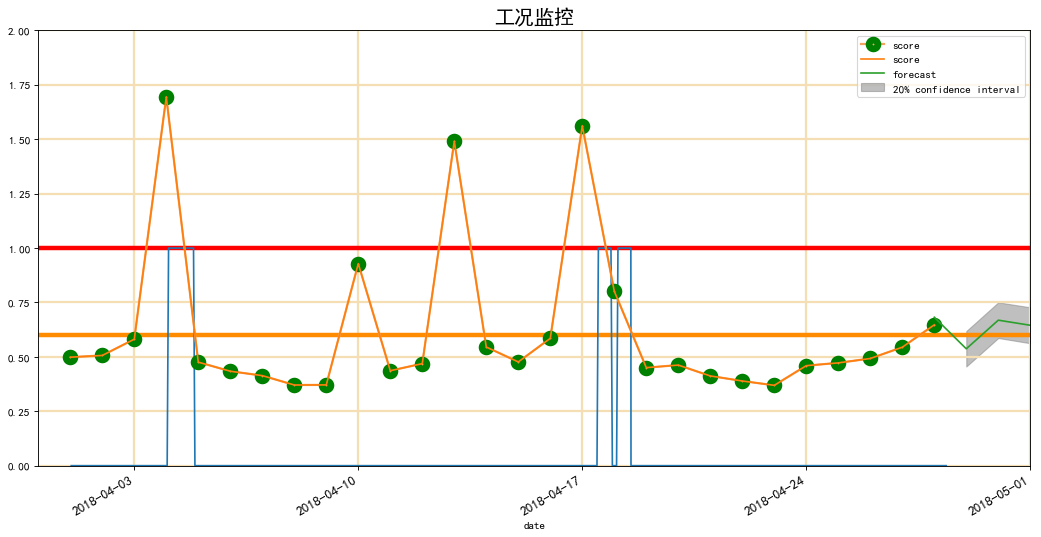

In [802]:
def plot_arima(df, flag_x, flag_y, AR = 3, DIF = 2, MA = 5):
    '''
    超参数( AR,DIF,MA ): (3,2,5)
    '''
    test_arima = df.copy()
    test_arima.set_index('date', inplace = True)  

    arma_mod = sm.tsa.ARMA(test_arima,(AR,DIF,MA )).fit()
    print(arma_mod.aic,arma_mod.bic,arma_mod.hqic)
    
    fig, ax = plt.subplots(figsize=(16, 8), dpi=80)
    plt.plot(flag_x, flag_y)
    plt.plot(df['date'],df['score'], color ='sandybrown',linewidth=2.0, linestyle='-',marker = 'o',mec = 'g',mew = 8.0)
    plt.hlines(0.6,xmin=df['date'].min()-timedelta(days=1),xmax = df['date'].max()+timedelta(days=3),colors='darkorange',lw = 4.0)
    plt.hlines(1.0,xmin=df['date'].min()-timedelta(days=1),xmax = df['date'].max()+timedelta(days=3),colors='red',lw = 4.0)
    plt.ylim(0,2)
    plt.xlim(df['date'].min()-timedelta(days=1),df['date'].max()+timedelta(days=3))
    plt.title('工况监控',fontsize = '18')
    plt.xticks(fontsize = '12')
    test_arima.loc['2018-04-01':].plot(ax=ax)
    fig = arma_mod.plot_predict(test_arima.index.max(), 
                                test_arima.index.max() + timedelta(days=3), 
                                dynamic=False, ax=ax, 
                                plot_insample=False, 
                                alpha=0.8)
    plt.grid(True, linestyle = "-", color = "wheat", linewidth = 2.0)
    ser_pred = arma_mod.predict(test_arima.index.max(), test_arima.index.max() + timedelta(days=3))
    df_pred = pd.DataFrame(data=ser_pred, index = ser_pred.index, columns=['score'])
    res = test_arima.append(df_pred)
    return res
    
res = plot_arima(df_all, device_data_all.index, FLAG_copy)

In [660]:
# 存储score
res['date'] = res.index
res.to_csv('./data/'+str(UNIQUENO)+'_score.csv',index=False)

In [708]:
# 存储bias
def construct_res_bias(df_device_data_bias_all, res,thresh=4):
    res_bias_ls = []
    for date in res.index.values[:-thresh]:
        date_str = datetime.strftime(pd.to_datetime(date),'%Y-%m-%d')
        df = df_device_data_bias_all[(df_device_data_bias_all.index>pd.to_datetime(date_str+' 00:00:00'))&(df_device_data_bias_all.index<pd.to_datetime(date_str+' 23:59:59'))]
        columns_filter = [column for column in df.columns if column.find('bias')!=-1]
        wc_sr = df[columns_filter].abs().mean()
        res_bias_ls.append(pd.DataFrame(data=(wc_sr/wc_sr.sum()).values.reshape(1,14),columns=columns_filter))
        
    res_bias = pd.concat(res_bias_ls,axis=0,copy=False,ignore_index=True)
    res_bias['date'] = pd.to_datetime(res.index.values[:-thresh])
    return res_bias


res_bias = construct_res_bias(device_data_bias_all, res)
res_bias.head()

,ENGINERUNTIMES_bias,ACCWORKTIMES_bias,ACCRUNTIMES_bias,FUELUSETOTAL_bias,CURRENTFAULTCOUNT1_bias,ALTITUDE_bias,COOLANTTEMPERATURE_bias,ELCANDVOL_bias,PRESSURE_bias,INTAKETEMPERATURE_bias,LUBRICATINGOILPRESSURE_bias,SATELLITE_bias,GSMSIGNAL_bias,THROTTLECURRENT_bias,date
0,0.023183,0.018587,0.000000,0.025386,0.001011,0.145335,0.051382,0.004069,0.031735,0.119833,0.138158,0.044982,0.075225,0.321116,2018-04-01
1,0.022402,0.016771,0.000000,0.024148,0.000982,0.165220,0.049780,0.004390,0.029265,0.124080,0.155087,0.052808,0.056833,0.298234,2018-04-02
2,0.032707,0.012965,0.000000,0.033934,0.000808,0.127727,0.056137,0.005674,0.043979,0.106985,0.189290,0.050749,0.046164,0.292883,2018-04-03
3,0.060766,0.060442,0.058416,0.060989,0.059629,0.051353,0.067873,0.060379,0.066797,0.082937,0.112739,0.061014,0.056813,0.139851,2018-04-04
4,0.007989,0.013593,0.000000,0.009224,0.000972,0.153550,0.037523,0.004375,0.024172,0.190193,0.143640,0.052321,0.068680,0.293768,2018-04-05


In [709]:
res_bias.to_csv('./data/'+str(UNIQUENO)+'_bias.csv',index=False)

In [710]:
res_bias.shape

(28, 15)

In [580]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
date     28 non-null datetime64[ns]
score    28 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 528.0 bytes


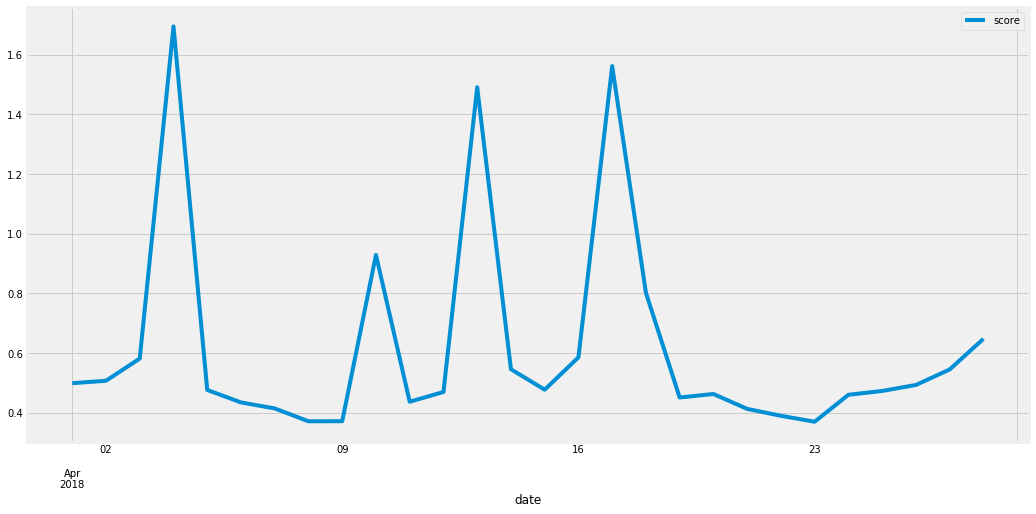

In [182]:
# diff level = 0
test_arima.plot(figsize= (16,8))

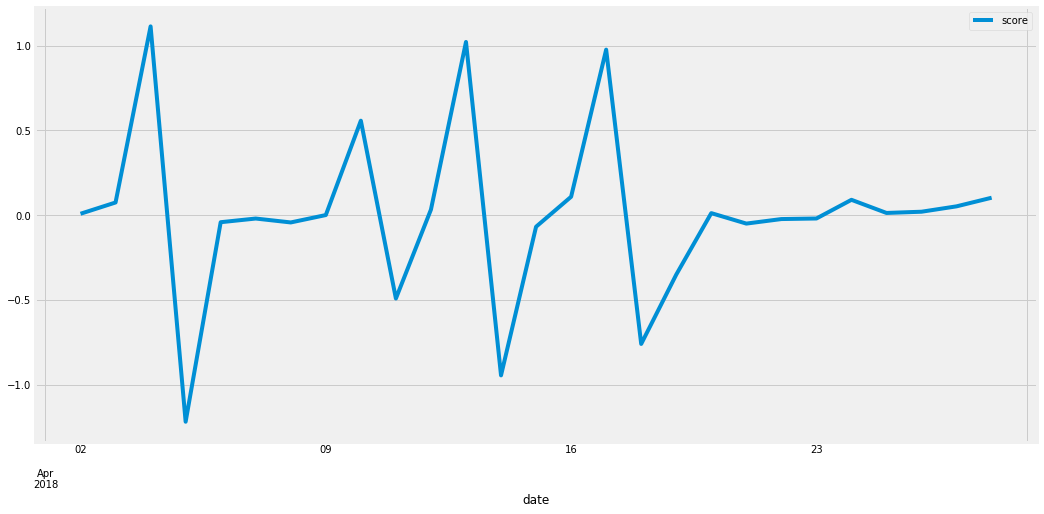

In [183]:
# diff level = 1
diff1 = test_arima.copy().diff(1)
diff1.plot(figsize= (16,8))

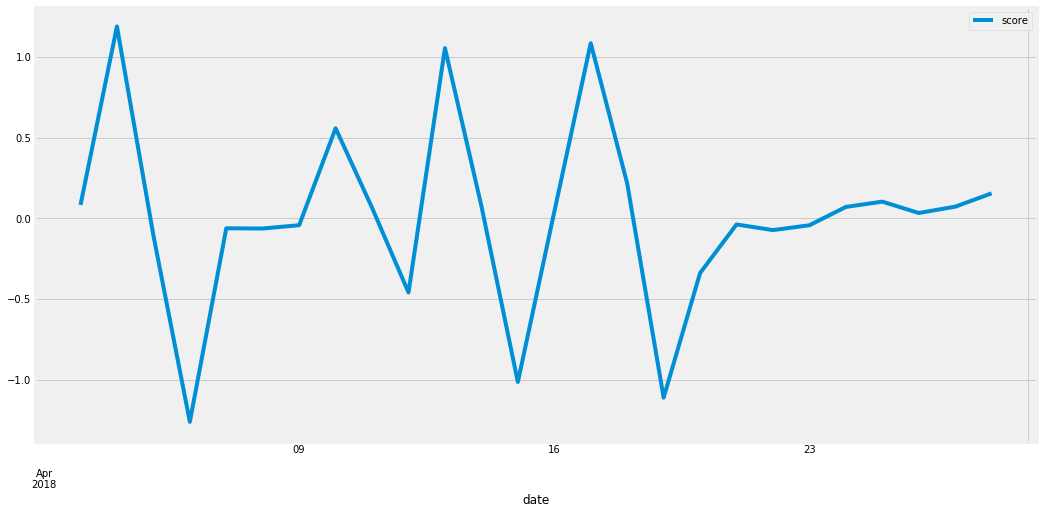

In [184]:
# diff level = 2
diff2 = test_arima.copy().diff(2)
diff2.plot(figsize= (16,8))

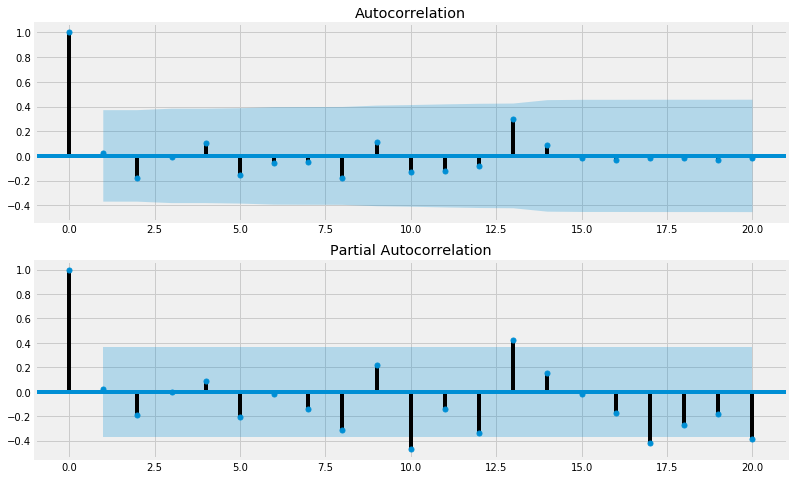

In [185]:
# diff = 0
test_arima_score = test_arima['score'].copy()
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(test_arima_score[:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(test_arima_score[:],lags=20,ax=ax2)


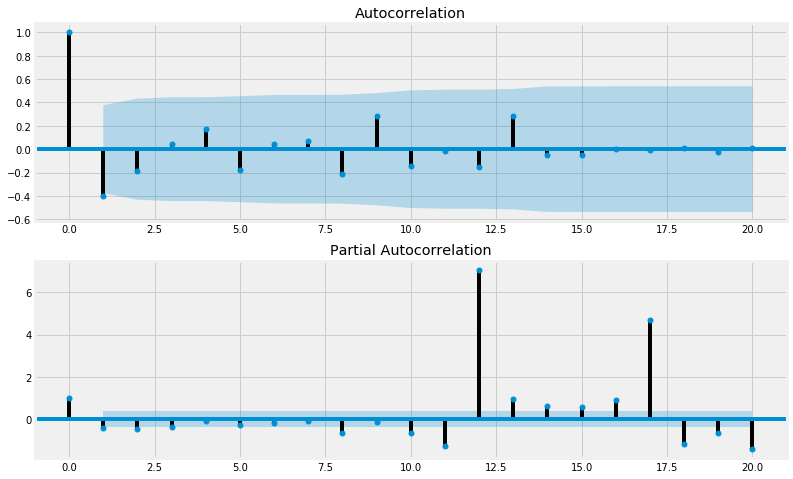

In [186]:
# diff = 1
test_arima_score_diff1 = diff1['score'].copy()
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(test_arima_score_diff1[1:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(test_arima_score_diff1[1:],lags=20,ax=ax2)